In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def set_plots_size_params(size):
    # Adapted from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
    bigger = size * 1.2
    slightly_bigger = size * 1.1
    plt.rc('font', size=size)                        # controls default text sizes
    plt.rc('axes', titlesize=bigger)                 # fontsize of the axes title
    plt.rc('axes', labelsize=slightly_bigger)        # fontsize of the x and y labels
    plt.rc('xtick', labelsize=size)                  # fontsize of the tick labels
    plt.rc('ytick', labelsize=size)                  # fontsize of the tick labels
    plt.rc('legend', fontsize=size)                  # legend fontsize
    plt.rc('figure', figsize=(0.75*size, size/2))    # size of figure
    return
set_plots_size_params(20)

In [3]:
def these_muts_chance(mutations, fitness_distribution):
    return np.product(np.power(fitness_distribution, mutations))


def poisson(mu, k):
    return math.exp(-mu) * (mu**k) / math.factorial(k)


def get_mutation_probs(mutation_rate, log10_virions_num=10):
    probs = dict()
    for num_of_muts in range(20):
        prob = round(poisson(mutation_rate, num_of_muts), log10_virions_num)  
        if prob > 0:
            probs[num_of_muts] = prob
    return probs


def get_mutations(mutation_rate, fitness_distribution, log10_virions_num, max_mutations=20):
    possible_mutations = []
    for a1 in range(max_mutations+1):
        for a2 in range(max_mutations+1):
            for a3 in range(max_mutations+1):
                perm = (a1,a2,a3)
                if sum(perm)>max_mutations or perm in possible_mutations:
                    continue
                possible_mutations.append(perm)
    possible_mutations = tuple(possible_mutations)
    this_many_muts_chance = get_mutation_probs(mutation_rate, log10_virions_num)
    mutations_prob = dict()
    for mut_tuple in possible_mutations:
        num_of_muts = sum(mut_tuple)
        if num_of_muts in this_many_muts_chance.keys():  
            mut_prob = this_many_muts_chance[num_of_muts] * these_muts_chance(mut_tuple, fitness_distribution)
            mut_prob = round(mut_prob, log10_virions_num) # muts are likely to occur with this many virions
            if mut_prob > 0:
                mutations_prob[mut_tuple] = mut_prob
    return mutations_prob

In [4]:
def normalize(array):
    return array / np.linalg.norm(array, ord=1)


def simulate_next_passage(fitness_values, genotype_freqs, mutation_probabilities, log10_virions_num=10):
    new_freqs = genotype_freqs.copy()
    for genotype, freq in genotype_freqs.items():
        for mutation, mut_freq in mutation_probabilities.items():
            new_genotype = tuple(np.add(genotype, mutation).tolist())
            fitness = np.product(np.power(fitness_values, new_genotype))
            new_freq = round(freq * mut_freq * fitness, log10_virions_num)
            if genotype == new_genotype:
                new_freqs[new_genotype] = new_freq
            else:
                if new_freq > 0:
                    if new_genotype not in new_freqs.keys():
                        new_freqs[new_genotype] = 0
                    new_freqs[new_genotype] += new_freq
    new_freqs = pd.Series(new_freqs)
    normalized = normalize(new_freqs)
    return normalized[round(normalized, log10_virions_num)!=normalized]


def model(fitness_distribution, fitness_values, mutation_rate, passages, log10_virions_num=10):
    passage = dict()
    passage[0] = {(0,0,0): 1}
    mutation_probabilities = get_mutations(mutation_rate, fitness_distribution, log10_virions_num)
    for i in range(passages):
        passage[i+1] = simulate_next_passage(fitness_values, passage[i], mutation_probabilities)
    return passage

<AxesSubplot:ylabel='Count'>

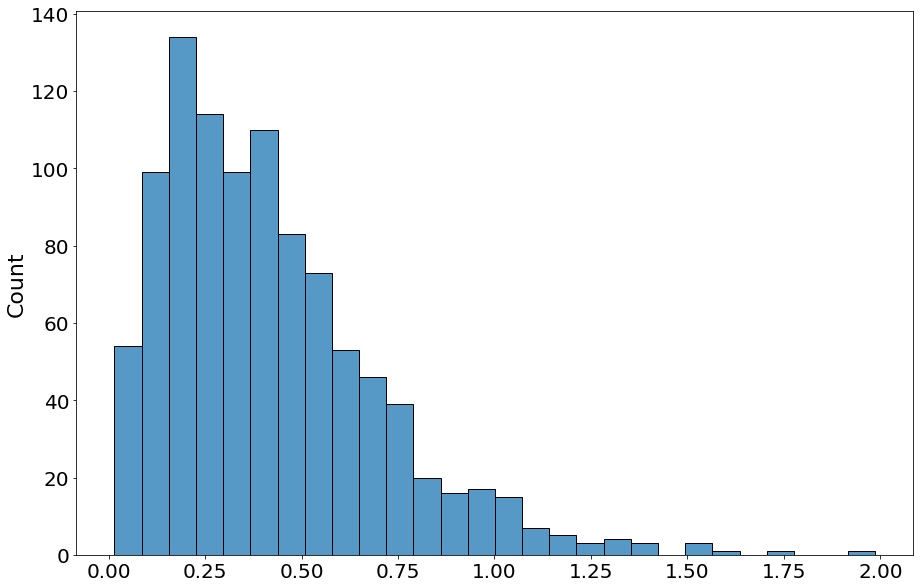

In [38]:
gamma_dist = np.random.gamma(2,0.2, 1000)
sns.histplot(gamma_dist)

In [39]:
adaptive = [x for x in gamma_dist if x>1.25]
syn = [x for x in gamma_dist if (x<1.25) and (x>0.75)]
deleterious = [x for x in gamma_dist if x<0.75]

In [40]:
fitness_distribution = [len(deleterious)/1000, len(syn)/1000, len(adaptive)/1000]
fitness_distribution

[0.882, 0.103, 0.015]

In [41]:
fitness_values = [np.mean(deleterious), np.mean(syn), np.mean(adaptive)]
fitness_values

[0.34262554052160954, 0.9158470804980259, 1.4515773910165035]

In [42]:
mutation_rate = 2.1
passages = 10

p = model(fitness_distribution, fitness_values, mutation_rate, passages)

In [43]:
data = pd.DataFrame(p)
data

0             1             2         3         4             5   \
0  0 0  1.0  4.424033e-01  6.460086e-01  0.725293  0.737048  7.115965e-01   
     1  NaN  2.022875e-02  4.287748e-02  0.069879  0.103078  1.444593e-01   
     2  NaN  4.624767e-04  1.422952e-03  0.003366  0.007208  1.466314e-02   
     3  NaN  7.048818e-06  3.148174e-05  0.000108  0.000336  9.922400e-04   
     4  NaN  8.020284e-08  5.199060e-07  0.000003  0.000012  5.012680e-05   
...     ...           ...           ...       ...       ...           ...   
10 0 7  NaN           NaN           NaN       NaN       NaN           NaN   
   1 0  NaN           NaN  1.192445e-09       NaN       NaN  7.884175e-10   
     1  NaN           NaN           NaN       NaN       NaN           NaN   
11 0 0  NaN           NaN  2.384890e-09       NaN       NaN           NaN   
     1  NaN           NaN           NaN       NaN       NaN           NaN   

              6             7             8             9             10  
0  0 0  0.659678  5.816355e-01  4.791077e-01  3.566068e-01  1.936734e-01  
     1  0.194395  2.487957e-01  2.974852e-01  3.214119e-01  2.533859e-01  
     2  0.028642  5.321141e-02  9.235649e-02  1.448453e-01  1.657544e-01  
     3  0.002813  7.587087e-03  1.911516e-02  4.351660e-02  7.228627e-02  
     4  0.000206  8.076238e-04  2.953603e-03  9.760440e-03  2.353480e-02  
...          ...           ...           ...           ...           ...  
10 0 7       NaN           NaN           NaN           NaN  4.435052e-10  
   1 0       NaN           NaN  1.345336e-09           NaN           NaN  
     1       NaN  7.200075e-10           NaN           NaN  4.435052e-10  
11 0 0       NaN  7.200075e-10           NaN  6.078198e-10           NaN  
     1       NaN           NaN  6.726678e-10           NaN           NaN  

[853 rows x 11 columns]

In [44]:
rising_muts = data.sort_values(by=10, ascending=False).head(10).index

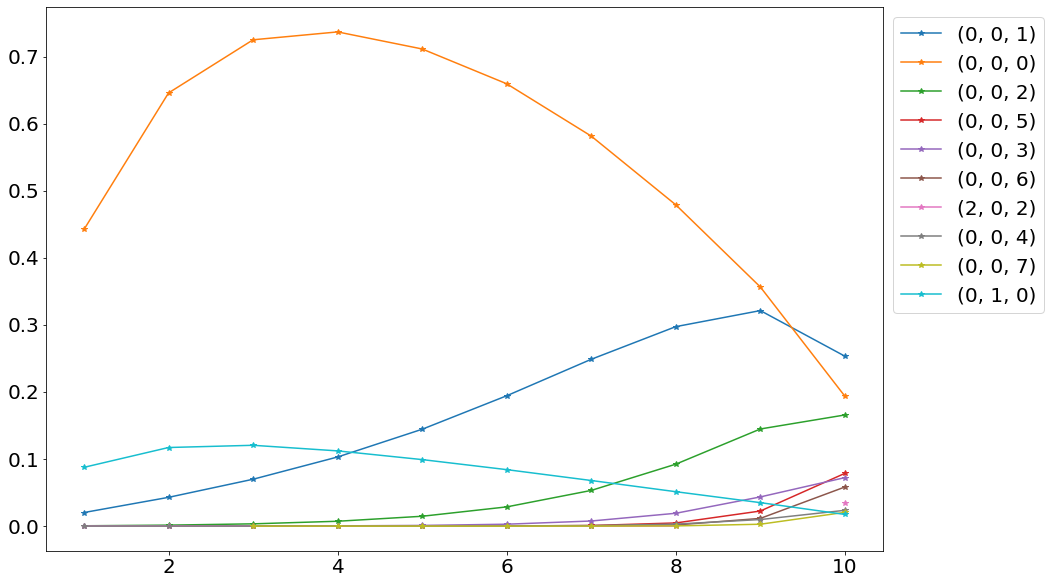

In [45]:
for mut in rising_muts:
    plt.plot(data.loc[mut, 1:], label=mut, marker='*')
plt.legend(bbox_to_anchor=(1,1))

In [46]:
#TODO: wtf with the deleterious mutation appearing after nan?!?

In [47]:
data.loc[(2,0,2)]

0              NaN
1     1.552106e-05
2     5.605684e-06
3     1.556795e-06
4     3.916904e-07
5     9.382168e-08
6     2.119703e-08
7     4.320045e-09
8     6.726678e-10
9              NaN
10    3.416322e-02
Name: (2, 0, 2), dtype: float64

In [50]:
data.loc[(0,0,2)]

0          NaN
1     0.000462
2     0.001423
3     0.003366
4     0.007208
5     0.014663
6     0.028642
7     0.053211
8     0.092356
9     0.144845
10    0.165754
Name: (0, 0, 2), dtype: float64

In [51]:
data.loc[(0,0,1)]

0          NaN
1     0.020229
2     0.042877
3     0.069879
4     0.103078
5     0.144459
6     0.194395
7     0.248796
8     0.297485
9     0.321412
10    0.253386
Name: (0, 0, 1), dtype: float64

In [53]:
data.loc[(1,0,1)]

0          NaN
1     0.006419
2     0.004662
3     0.002603
4     0.001316
5     0.000632
6     0.000291
7     0.000128
8     0.000052
9     0.000019
10    0.000005
Name: (1, 0, 1), dtype: float64

In [49]:
data[(data[9].isna()) & (data[8].notna())].sort_values(by=10, ascending=False)

0         1             2         3             4             5   \
2  0 2 NaN  0.000016  5.605684e-06  0.000002  3.916904e-07  9.382168e-08   
   1 0 NaN  0.005882  9.235153e-04  0.000111  1.217974e-05  1.264622e-06   
3  1 7 NaN       NaN           NaN       NaN           NaN  7.884175e-09   
   2 6 NaN       NaN           NaN       NaN           NaN  2.049885e-08   
6  0 3 NaN       NaN  5.962225e-09       NaN  4.730159e-08           NaN   
...     ..       ...           ...       ...           ...           ...   
2  7 2 NaN       NaN           NaN       NaN           NaN  7.884175e-10   
4  6 2 NaN       NaN           NaN       NaN           NaN           NaN   
9  2 1 NaN       NaN           NaN       NaN           NaN           NaN   
10 1 0 NaN       NaN  1.192445e-09       NaN           NaN  7.884175e-10   
11 0 1 NaN       NaN           NaN       NaN           NaN           NaN   

                  6             7             8   9         10  
2  0 2  2.119703e-08  4.320045e-09  6.726678e-10 NaN  0.034163  
   1 0  1.256681e-07  1.224013e-08  1.345336e-09 NaN  0.006078  
3  1 7  3.785183e-09  1.440015e-09  6.726678e-10 NaN  0.000366  
   2 6  6.056293e-09  2.160023e-09  6.726678e-10 NaN  0.000101  
6  0 3  3.013006e-07  1.440015e-09  2.018004e-09 NaN  0.000019  
...              ...           ...           ...  ..       ...  
2  7 2           NaN           NaN  2.018004e-09 NaN       NaN  
4  6 2           NaN           NaN  6.726678e-10 NaN       NaN  
9  2 1           NaN           NaN  6.726678e-10 NaN       NaN  
10 1 0           NaN           NaN  1.345336e-09 NaN       NaN  
11 0 1           NaN           NaN  6.726678e-10 NaN       NaN  

[88 rows x 11 columns]

In [21]:
data.loc[(1,1,0)]

0              NaN
1     2.795631e-02
2     1.233424e-02
3     4.193117e-03
4     1.299477e-03
5     3.858143e-04
6     1.110023e-04
7     3.076331e-05
8     8.138101e-06
9     2.025156e-06
10    4.497875e-07
Name: (1, 1, 0), dtype: float64

In [20]:
data.loc[(0,1,0)]

0          NaN
1     0.091759
2     0.123337
3     0.127740
4     0.120607
5     0.109092
6     0.095621
7     0.080736
8     0.065068
9     0.049332
10    0.033394
Name: (0, 1, 0), dtype: float64

In [17]:
data

0             1             2             3         4             5   \
0  0 0  1.0  4.546044e-01  6.611718e-01  7.409468e-01  0.756949  7.408409e-01   
     1  NaN  1.646614e-02  3.442152e-02  5.544475e-02  0.081414  1.145285e-01   
     2  NaN  2.982089e-04  8.960171e-04  2.074456e-03  0.004378  8.852640e-03   
     3  NaN  3.600263e-06  1.554791e-05  5.173878e-05  0.000157  4.561409e-04   
     4  NaN  3.341139e-08  2.078438e-07  9.938502e-07  0.000004  1.810037e-05   
...     ...           ...           ...           ...       ...           ...   
10 0 0  NaN  7.424754e-10           NaN  4.575738e-09       NaN  2.397717e-09   
     1  NaN           NaN           NaN           NaN       NaN           NaN   
     2  NaN           NaN           NaN           NaN       NaN           NaN   
   1 0  NaN           NaN           NaN           NaN       NaN           NaN   
     1  NaN           NaN           NaN           NaN       NaN           NaN   

                  6             7             8             9             10  
0  0 0  7.026282e-01  6.419101e-01  5.597688e-01  4.592093e-01  3.363425e-01  
     1  1.561248e-01  2.050115e-01  2.569628e-01  3.029911e-01  3.189765e-01  
     2  1.734558e-02  3.273804e-02  5.897967e-02  9.995846e-02  1.512537e-01  
     3  1.284614e-03  3.484930e-03  9.024047e-03  2.198246e-02  4.781017e-02  
     4  7.326885e-05  2.856925e-04  1.063320e-03  3.723029e-03  1.163853e-02  
...              ...           ...           ...           ...           ...  
10 0 0           NaN  4.476291e-09           NaN  4.689413e-09           NaN  
     1  7.744958e-10           NaN  2.848478e-09           NaN  5.981217e-10  
     2           NaN           NaN           NaN           NaN  1.196243e-09  
   1 0  7.744958e-10           NaN  7.121195e-10           NaN           NaN  
     1           NaN           NaN           NaN           NaN  5.981217e-10  

[710 rows x 11 columns]

In [ ]:
TODO: wtf with the red